# Imports

In [2]:
import pandas as pd # import for dataframe handle
import numpy as np # import for math and array operations
import matplotlib.pyplot as plt # import for visual representation
#import seaborn as sns # import for visual representation

import re

from bs4 import BeautifulSoup
import requests

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

# Load Dataset

In [3]:
df = pd.read_csv('../raw_data/combine_df.csv')

In [4]:
new_df = df[['url', 'name', 'popular_tags', 'genre']].copy()

In [5]:
reviews_df = pd.read_csv('../raw_data/reviews.csv')

In [6]:
reviews_df

,url,clean_reviews
0,https://store.steampowered.com/app/379720/DOOM/,Very Positive
1,https://store.steampowered.com/app/578080/PLAY...,Mixed
2,https://store.steampowered.com/app/637090/BATT...,Mostly Positive
3,https://store.steampowered.com/app/221100/DayZ/,Mixed
4,https://store.steampowered.com/app/8500/EVE_On...,Mostly Positive
...,...,...
38016,https://store.steampowered.com/app/899836/Rock...,no value
38017,https://store.steampowered.com/app/899832/Rock...,no value
38018,https://store.steampowered.com/app/906840/Fant...,no value
38019,https://store.steampowered.com/app/906635/Mega...,no value


In [7]:
reviews_df.clean_reviews.value_counts()

no value                   17563
Mixed                       5507
Very Positive               4842
Positive                    4716
Mostly Positive             3841
Mostly Negative              979
Overwhelmingly Positive      331
Negative                     196
Very Negative                 39
Overwhelmingly Negative        7
Name: clean_reviews, dtype: int64

In [8]:
new_df.head()

,url,name,popular_tags,genre
0,https://store.steampowered.com/app/379720/DOOM/,DOOM,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",Action
1,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,"Survival,Shooter,Multiplayer,Battle Royale,PvP...","Action,Adventure,Massively Multiplayer"
2,https://store.steampowered.com/app/637090/BATT...,BATTLETECH,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Action,Adventure,Strategy"
3,https://store.steampowered.com/app/221100/DayZ/,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Action,Adventure,Massively Multiplayer"
4,https://store.steampowered.com/app/8500/EVE_On...,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Action,Free to Play,Massively Multiplayer,RPG,..."


In [9]:
new_df.shape

(38021, 4)

In [10]:
print(f"URL Null values: {new_df['url'].isnull().sum()}")
print(f"Names Null values: {new_df['name'].isnull().sum()}")
print(f"Tags Null values: {new_df['popular_tags'].isnull().sum()}")
print(f"Genre Null values: {new_df['genre'].isnull().sum()}")

URL Null values: 0
Names Null values: 14
Tags Null values: 133
Genre Null values: 396


In [11]:
ratings = pd.merge(new_df, reviews_df, on='url')

In [12]:
ratings.head()

,url,name,popular_tags,genre,clean_reviews
0,https://store.steampowered.com/app/379720/DOOM/,DOOM,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",Action,Very Positive
1,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,"Survival,Shooter,Multiplayer,Battle Royale,PvP...","Action,Adventure,Massively Multiplayer",Mixed
2,https://store.steampowered.com/app/637090/BATT...,BATTLETECH,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Action,Adventure,Strategy",Mostly Positive
3,https://store.steampowered.com/app/221100/DayZ/,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Action,Adventure,Massively Multiplayer",Mixed
4,https://store.steampowered.com/app/8500/EVE_On...,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Action,Free to Play,Massively Multiplayer,RPG,...",Mostly Positive


In [13]:
ratings['clean_reviews'].replace('no value', 'Mixed', inplace=True)

In [14]:
ratings['clean_reviews'].value_counts()

Mixed                      23070
Very Positive               4842
Positive                    4716
Mostly Positive             3841
Mostly Negative              979
Overwhelmingly Positive      331
Negative                     196
Very Negative                 39
Overwhelmingly Negative        7
Name: clean_reviews, dtype: int64

## Get Missing Names

In [15]:
def get_name(url):
    """
    Scrapes the url website for the game name
    
    Args:
        url (str): Link to the web page for a given game.
    
    Returns:
        str: Game name or if missing 'NaN' value.
    """
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try:
        return soup.find('h2', class_='pageheader').text.strip()
    except AttributeError:
        try:
            return soup.find('div', class_='apphub_AppName').text.strip()
        except AttributeError:
            return float('nan')

In [16]:
def get_tags(url):
    """
    Scrapes the url website for the game name
    
    Args:
        url (str): Link to the web page for a given game.
    
    Returns:
        str: Game name or if missing 'NaN' value.
    """
    response = requests.get(url).text
    soup = BeautifulSoup(response, "html.parser")
    try:
        tags = soup.find_all('a', class_='app_tag')
        return ' '.join([tags[i].text.strip() for i in range(len(tags))])
    except AttributeError:
        return float('nan')

In [17]:
for index in new_df[new_df['name'].isnull()].index:
    new_df.loc[index, 'name'] = get_name(new_df.loc[index, 'url'])

In [18]:
new_df.drop(list(new_df[new_df['name'].isnull()]['url'].index), inplace=True)

## Get Tags

In [19]:
for index in new_df[new_df['popular_tags'].isnull()].index:
    new_df.loc[index, 'popular_tags'] = get_tags(new_df.loc[index, 'url'])

In [20]:
new_df.isnull().sum()

url               0
name              0
popular_tags      0
genre           392
dtype: int64

### Replace missing values by empty string

In [21]:
new_df.fillna('', inplace=True)

### Combine tags & genre

In [22]:
#new_df['name'] = new_df['name'].apply(lambda x: x.lower())
new_df['popular_tags'] = new_df['popular_tags'].apply(lambda x: x.lower())
new_df['genre'] = new_df['genre'].apply(lambda x: x.lower())

In [23]:
new_df['popular_tags'] = new_df['popular_tags'].apply(lambda x: x.replace(',', ' '))
new_df['genre'] = new_df['genre'].apply(lambda x: x.replace(',', ' '))

In [24]:
new_df.head()

,url,name,popular_tags,genre
0,https://store.steampowered.com/app/379720/DOOM/,DOOM,fps gore action demons shooter first-person gr...,action
1,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,survival shooter multiplayer battle royale pvp...,action adventure massively multiplayer
2,https://store.steampowered.com/app/637090/BATT...,BATTLETECH,mechs strategy turn-based turn-based tactics s...,action adventure strategy
3,https://store.steampowered.com/app/221100/DayZ/,DayZ,survival zombies open world multiplayer pvp ma...,action adventure massively multiplayer
4,https://store.steampowered.com/app/8500/EVE_On...,EVE Online,space massively multiplayer sci-fi sandbox mmo...,action free to play massively multiplayer rpg ...


In [25]:
new_df['metadata'] = new_df[['popular_tags', 'genre']].apply(lambda x: ' '.join(x), axis = 1)

In [26]:
new_df['metadata'] = new_df['metadata'].apply(
    lambda x: ' '.join(list(set(x.split())))
)

## Count Vectorizer

In [27]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(new_df['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=new_df.index.tolist())
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,404,405,406,407,408,409,410,411,412,413
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
count_df.shape

(38017, 414)

## Dimensionality reduction

In [29]:
svd = TruncatedSVD(n_components=60)
latent_df = svd.fit_transform(count_df)

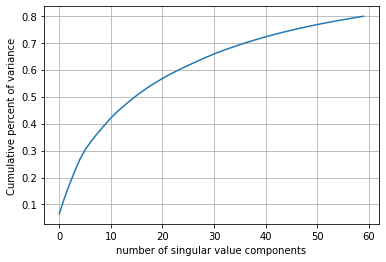

In [30]:
# Plot variance as a function of the number of components.
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [31]:
# keep the first 100 number of latent components.
n = 60 
latent_df = pd.DataFrame(latent_df[:,0:n], index=new_df.name.tolist())
latent_df.shape

(38017, 60)

## Encoding Reviews

In [32]:
ratings.head()

,url,name,popular_tags,genre,clean_reviews
0,https://store.steampowered.com/app/379720/DOOM/,DOOM,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",Action,Very Positive
1,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,"Survival,Shooter,Multiplayer,Battle Royale,PvP...","Action,Adventure,Massively Multiplayer",Mixed
2,https://store.steampowered.com/app/637090/BATT...,BATTLETECH,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Action,Adventure,Strategy",Mostly Positive
3,https://store.steampowered.com/app/221100/DayZ/,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Action,Adventure,Massively Multiplayer",Mixed
4,https://store.steampowered.com/app/8500/EVE_On...,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Action,Free to Play,Massively Multiplayer,RPG,...",Mostly Positive


#### Steam Review Scale

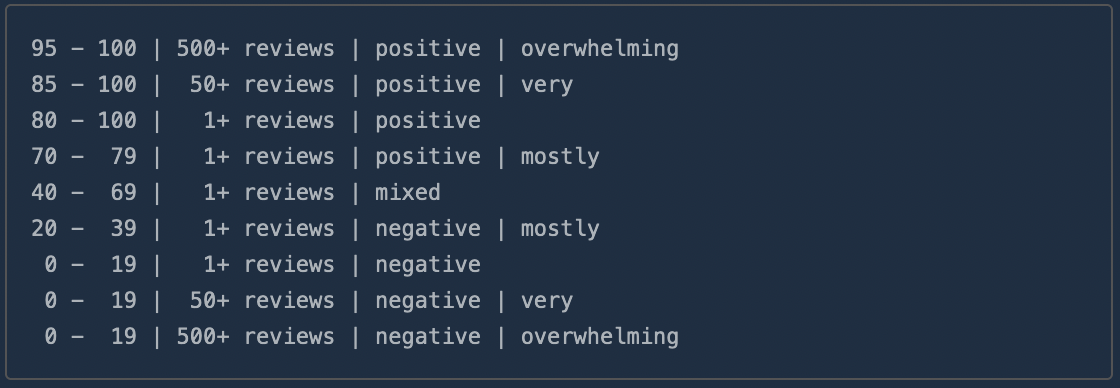

In [33]:
rating_cat = [
    "Overwhelmingly Negative",
    "Very Negative",
    "Negative",
    "Mostly Negative",
    'Mixed',
    "Mostly Positive",
    "Positive",
    "Very Positive",
    "Overwhelmingly Positive"
]

rating_cat

['Overwhelmingly Negative',
 'Very Negative',
 'Negative',
 'Mostly Negative',
 'Mixed',
 'Mostly Positive',
 'Positive',
 'Very Positive',
 'Overwhelmingly Positive']

In [34]:
encoder = OrdinalEncoder(
    categories=[rating_cat],
    dtype=np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

In [35]:
encoder.fit(ratings[['clean_reviews']])

OrdinalEncoder(categories=[['Overwhelmingly Negative', 'Very Negative',
                            'Negative', 'Mostly Negative', 'Mixed',
                            'Mostly Positive', 'Positive', 'Very Positive',
                            'Overwhelmingly Positive']],
               dtype=<class 'numpy.int64'>, handle_unknown='use_encoded_value',
               unknown_value=-1)

In [36]:
ratings['review_score'] = encoder.transform(ratings[['clean_reviews']])

In [37]:
ratings.head()

,url,name,popular_tags,genre,clean_reviews,review_score
0,https://store.steampowered.com/app/379720/DOOM/,DOOM,"FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",Action,Very Positive,7
1,https://store.steampowered.com/app/578080/PLAY...,PLAYERUNKNOWN'S BATTLEGROUNDS,"Survival,Shooter,Multiplayer,Battle Royale,PvP...","Action,Adventure,Massively Multiplayer",Mixed,4
2,https://store.steampowered.com/app/637090/BATT...,BATTLETECH,"Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...","Action,Adventure,Strategy",Mostly Positive,5
3,https://store.steampowered.com/app/221100/DayZ/,DayZ,"Survival,Zombies,Open World,Multiplayer,PvP,Ma...","Action,Adventure,Massively Multiplayer",Mixed,4
4,https://store.steampowered.com/app/8500/EVE_On...,EVE Online,"Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...","Action,Free to Play,Massively Multiplayer,RPG,...",Mostly Positive,5


In [38]:
ratings['review_score'].isnull().sum()

0

## Cosine Similarity

In [39]:
latent_df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
DOOM,1.676195,2.105322,-0.064976,0.046109,1.590694,0.253316,0.285627,0.246681,0.177751,-0.893866,...,0.062970,-0.118730,0.080702,-0.094503,0.059888,-0.008941,-0.083204,-0.008741,-0.123125,-0.296163
PLAYERUNKNOWN'S BATTLEGROUNDS,2.109631,0.946554,-0.927833,1.684248,1.352540,-1.001331,-0.269810,0.804317,-0.930870,-0.535359,...,-0.148052,0.154580,-0.054791,0.508719,0.003149,-0.300678,0.099788,-0.019508,0.153426,0.046736
BATTLETECH,2.171913,1.560601,0.657015,1.473206,0.082363,0.195178,0.459364,-0.664535,-0.028974,-0.125568,...,0.209380,0.166033,-0.101073,0.147768,0.368335,0.316753,0.212446,0.152864,-0.035948,0.059014
DayZ,2.353306,0.558347,-1.009603,0.686667,1.055882,-1.155471,-0.907601,1.100237,-0.369181,-0.073831,...,-0.153482,0.151538,-0.029444,-0.012645,0.412436,0.348863,0.056025,0.399134,-0.315831,0.003680
EVE Online,1.660081,0.384765,-0.527736,1.661191,1.437865,-0.660947,0.794314,-0.112490,0.042146,0.285910,...,0.101405,0.246357,-0.043861,0.072937,0.178642,-0.275929,0.244356,0.479993,-0.051036,0.116783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rocksmith® 2014 Edition – Remastered – Sabaton - “Ghost Division”,0.433692,-0.805664,0.325163,-0.183366,0.590729,-0.473297,0.081988,-0.341396,0.012893,0.211777,...,0.001516,-0.014307,-0.028424,-0.027077,0.003758,-0.003025,-0.019038,0.006730,-0.008345,-0.002868
Rocksmith® 2014 Edition – Remastered – Stone Temple Pilots - “Trippin’ on a Hole in a Paper Heart”,0.433692,-0.805664,0.325163,-0.183366,0.590729,-0.473297,0.081988,-0.341396,0.012893,0.211777,...,0.001516,-0.014307,-0.028424,-0.027077,0.003758,-0.003025,-0.019038,0.006730,-0.008345,-0.002868
Fantasy Grounds - Quests of Doom 4: A Midnight Council of Quail (5E),1.621020,-0.164407,0.478650,2.108526,-1.502958,0.404545,0.408500,-0.088293,-0.458117,-0.144723,...,-0.043502,0.060513,-0.018918,0.005405,-0.010118,-0.112776,0.092743,-0.173749,0.095885,-0.034250
Mega Man X5 Sound Collection,0.384769,0.216225,-0.655966,-0.154470,0.113957,0.067525,0.132508,-0.352235,0.030513,-0.080813,...,0.016301,-0.009087,-0.001364,-0.001491,0.003778,-0.009500,-0.001975,-0.002094,0.010633,-0.004026


In [40]:
def print_games(games, start):
    """
    Displays the games in a menu format
    
    Args:
        games (list): List of games
        start (int): Index starting value
    """
    for index, game in enumerate(games, start=start):
        print(f"{index} - {game}")


def get_game(df):
    """
    Find the game the user wants from the dataframe
    
    Args:
        df (Dataframe): Games dataframe
    
    Returns:
        str: Name of the game choosen by the user
    """

    name = input("What game are you looking for?\n>") # ask the user for a game

    # checks how many possible games exist in the dataframe
    game_options = list(
        new_df[df['name'].\
               str.contains(name, case=False) == True]['name']
    )
    
    # Game don't exists in the data frame
    if len(game_options) == 0:
        print('Not Found')
        return None
    
    # If there is only one game
    if len(game_options) == 1:
        return game_options[0]
    
    # Less then 10 games only one page
    if len(game_options) <= 10:
        print_games(game_options, 0)
        option = input('Choose the number for the game you want:\n> ')
        return game_options[int(option)]
    
    # Loops the games 10 by 10
    page_num = int(len(game_options)/10) # number of iterations to show games
    last_index = 11  
    prev_index = 0
    
    for page in range(page_num+1):
        print_games(game_options[prev_index:last_index], prev_index)
        
        # after each iterations ask the user if the game is in that page
        option = input('Choose the number for the game you want(-1 if not shown):\n> ')
        if prev_index <= int(option) <= last_index:
            return game_options[int(option)]
        
        # if it has shown all pages it means it was not in the dataset
        if last_index >= page_num * 10:
            return 'Not Found'
        
        # updates the index for the next page
        prev_index = last_index
        last_index += 10

In [43]:
game = get_game(new_df)

What game are you looking for?
>doom
0 - DOOM
1 - Ultimate Doom
2 - DOOM Eternal
3 - DOOM 3
4 - DOOM VFR
5 - Doom 3: BFG Edition
6 - DOOM II
7 - DOOM 3 Resurrection of Evil
8 - Deponia Doomsday
9 - Final DOOM
10 - Deep Dungeons of Doom
Choose the number for the game you want(-1 if not shown):
> 0


In [44]:
v1 = np.array(latent_df.loc['DOOM']).reshape(1, -1)

sim1 = cosine_similarity(latent_df, v1).reshape(-1)

games_dic = {'games': sim1}

recommendation_df = pd.DataFrame(games_dic, index = latent_df.index)

recommendation_df.sort_values(by='games', ascending=False).head(10)

,games
DOOM,1.000000
QUAKE II,0.919612
Unreal Tournament: Game of the Year Edition,0.915532
QUAKE,0.904239
Final DOOM,0.898082
Painkiller: Black Edition,0.889123
Painkiller Hell & Damnation,0.883120
Unreal Tournament 3 Black,0.877957
Unreal Tournament 2004: Editor's Choice Edition,0.866789
Ultimate Doom,0.861083
